# Testing TensorFlow Lite models

This notebooks shows some ways for debugging TensorFlow Lite models and comparing them with the original implementations in TensorFlow.

For more details, take a look at blog posts:

- [Testing TensorFlow Lite image classification model](https://thinkmobile.dev/testing-tensorflow-lite-image-classification-model/) - converting TensorFlow to TensorFlow Lite and comparing models side by side.
- [Automate testing of TensorFlow Lite model implementation](https://thinkmobile.dev/automate-testing-of-tensorflow-lite-model-implementation/) - Testing TensorFlow Lite model on Android app with Espresso and instrumented tests.

### How accurate is this notebook?

It's worth to mention, that this notebook shows just some basic ideas for eye-comparison between TensorFlow and TensorFlow Lite models. It doesn't check them for speed and any other factor of performance and doesn't do any accurate side-by-side comparison. But still can be helpful with answering the question "why a model implemented on the app doesn't work the same like on notebook?".

## TensorFlow 2.0 and Colaboratory

This notebook can be executed in Colaboratory. It requires some changes to make it working on Docker environment described in linked blog post.

Examples presented in this notebook are built on top of TensorFlow 2.0 stable version.

### GPU support
The good thing about Colab is that it supports GPU envinronment without additional work. Just open **Runtime -> Change runtime type** and make sure that GPU is selected. The training process of this notebook should be about 3 times faster than on CPU env.

In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
%tensorflow_version 2.x
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Conv1D, Conv2D, AveragePooling1D,AveragePooling2D, BatchNormalization, UpSampling1D, Activation, MaxPooling1D, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate
from tensorflow.keras.models import Model

from datetime import datetime


In [ ]:
!pip install tensorflow-gpu==2.0.0
!pip install tensorflow_hub

     |████████████████████████████████| 380.8 MB 37 kB/s 
     |████████████████████████████████| 449 kB 43.9 MB/s 
     |████████████████████████████████| 3.8 MB 35.4 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=3d2731505160cd24242ece441829a2b122b87ce663e0d20b7cc58f543423601d
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
#import tensorflow_hub as hub
import numpy as np

For better data visualization we'll use [Pandas library](https://pandas.pydata.org/).

In [ ]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf_device="GPU:0"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14051940368170484125
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14456049393627200585
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls gdrive/My\ \Drive/STUDY/PhD\ \Electrical\ \and\ \Computer\ \Eng\ \-\ \UTSA/2022_Spring/Advanced\ \Robotics\ \AI/Robotic\ \Project/AI/Codes/Models/

model_conv1D.h5      modelLR.h	   model_SVM.h	  model_SVM.sh5
model_conv2D.h5      modelLR.h5    model_SVM.h5   model_tensorflow.h5
model_conv2D.tflite  model_MLPC.h  model_SVM.sav


In [ ]:
path_model = "gdrive/My Drive/STUDY/PhD Electrical and Computer Eng - UTSA/2022_Spring/Advanced Robotics AI/Robotic Project/AI/Codes/Models/"

## Simple transfer learning

For the sake of the notebook completness, we will do simple transfer learning, to create our own machine learning model. 

If you want to know more about it, I highly recommend to check Udacity ["Tensorflow free course"](https://classroom.udacity.com/courses/ud187), where the inspiration for transfer learning code came from.

### Dataset preparation


## Processing the data

Download the data, if not already on disk and load it as numpy arrays

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Hugo Chavez
[[254.       254.       251.66667  ...  65.333336  50.666668  40.333332]
 [253.33333  251.33333  247.33333  ...  66.666664  52.        42.666668]
 [240.66667  231.66667  211.66667  ...  62.        49.        42.      ]
 ...
 [ 74.333336  54.        31.666666 ...  97.666664  93.        90.      ]
 [ 65.333336  47.        30.333334 ...  91.666664  92.        86.333336]
 [ 59.333332  44.333332  32.333332 ...  87.333336  88.666664  86.666664]]


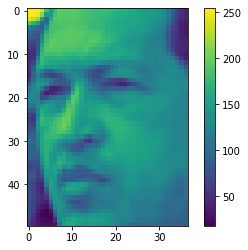

In [ ]:
print(lfw_people.target_names[lfw_people.target[0]])
print(lfw_people.images[0])
plt.imshow(lfw_people.images[0])
plt.colorbar()
plt.show()

In [ ]:
print("Image shape:", lfw_people.images.shape)
print("X shape: ", X.shape)
print("Number of elements of the image in a vector ( h x w =",h,"*",w,"=",h*w,")")


Image shape: (1288, 50, 37)
X shape:  (1288, 1850)
Number of elements of the image in a vector ( h x w = 50 * 37 = 1850 )


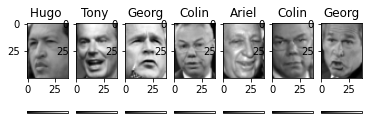

In [ ]:
fig = plt.figure()
n = n_classes
level = 1
for i in range(0,n):
  ax = fig.add_subplot(1, n, i+1)
  face = lfw_people.images[i*level]
  imgplot = plt.imshow(face, cmap='gray')
  ax.set_title(target_names[y[i*level]][:5])
  plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

#plt.imshow(lfw_people.images[0], cmap='gray')

In [ ]:
class_names = target_names
class_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [ ]:
image_batch_train, image_batch_test, label_batch_train, label_batch_test = train_test_split(lfw_people.images, y, test_size=0.25, random_state=42)

y_train = to_categorical(label_batch_train)
y_test = to_categorical(label_batch_test)
# Learn more about data batches

#image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
print("Image batch shape: ", image_batch_test.shape)
print("Label batch shape: ", label_batch_test.shape)

Image batch shape:  (966, 50, 37)
Label batch shape:  (966,)
Image batch shape:  (322, 50, 37)
Label batch shape:  (322,)


### Model architecture, training

As a base model for transfer learning, we'll use MobileNet v2 model stored on TensorFlow Hub. Presented model can be used only in TensorFlow 2.0 implementation (TF Hub contains also models for TensorFlow 1.x).

Basic information about feature vector:
- Input shape: 224x224x3 (224x224 pixels, 3 chanels each, RGB format),
- Each channel has value in range [0, 1],
- Feature vector output shape: 1280 (number of labels classified by MobileNet is 1001 - this info isn't important here)

For more details check feature vector page:
https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4

In [ ]:
img_height = 50
img_width = 37

def UNetConv2D(inp = (img_height, img_width, 1), nclass = 7):
   
    kernel_size=7
    strides=1
    x = 32

    inputs = Input(shape=inp)
    conv1 = Conv2D(x,kernel_size, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(x,kernel_size, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    #pool1 = AveragePooling2D(pool_size=4)(conv1)

    conv2 = Conv2D(x*2,kernel_size, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(x*2,kernel_size, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    #pool2 = AveragePooling2D(pool_size=4)(conv2)

    conv3 = Conv2D(x*4,kernel_size, activation='relu', padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(x*4,3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    #pool3 = AveragePooling2D(pool_size=4)(conv3)

    conv4 = Conv2D(x*8,kernel_size, activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(x*8,kernel_size, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    #pool4 = AveragePooling2D(pool_size=4)(conv4)

    conv5 = Conv2D(x*16,kernel_size, activation='relu', padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(x*16, kernel_size, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    '''up6 = concatenate([UpSampling1D(size=2)(conv5), conv4], axis=2)
    conv6 = Conv2D(x*8, kernel_size, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(x*8, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([UpSampling1D(size=2)(conv6), conv3], axis=2)
    conv7 = Conv2D(x*4, kernel_size, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(x*4,kernel_size, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([UpSampling1D(size=2)(conv7), conv2], axis=2)
    conv8 = Conv2D(x*2,kernel_size, activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(x*2, kernel_size, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([UpSampling1D(size=2)(conv8), conv1], axis=2)
    conv9 = Conv2D(x, kernel_size, activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(x, kernel_size, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)'''
    
    flatten = Flatten(name = 'flatten')(conv5)       
    conv10 = Dense(nclass, activation='softmax', name='conv10')(flatten)


    model = Model(inputs=[inputs], outputs=[conv10]) 
    opt = optimizers.RMSprop(0.001)  

    # model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])     
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])    
     
    #model.summary()

    return model

In [ ]:
img_height = 50
img_width = 37

def UNetConv1D(inp = (img_height, img_width), nclass = 7):
   
    kernel_size=7
    strides=1
    x = 32

    inputs = Input(shape=inp)
    conv1 = Conv1D(x,kernel_size, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv1D(x,kernel_size, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = AveragePooling1D(pool_size=4)(conv1)

    conv2 = Conv1D(x*2,kernel_size, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(x*2,kernel_size, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = AveragePooling1D(pool_size=4)(conv2)

    conv3 = Conv1D(x*4,kernel_size, activation='relu', padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv1D(x*4,3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = AveragePooling1D(pool_size=4)(conv3)

    conv4 = Conv1D(x*8,kernel_size, activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv1D(x*8,kernel_size, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = AveragePooling1D(pool_size=4)(conv4)

    conv5 = Conv1D(x*16,kernel_size, activation='relu', padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv1D(x*16, kernel_size, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    '''up6 = concatenate([UpSampling1D(size=2)(conv5), conv4], axis=2)
    conv6 = Conv1D(x*8, kernel_size, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv1D(x*8, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([UpSampling1D(size=2)(conv6), conv3], axis=2)
    conv7 = Conv1D(x*4, kernel_size, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv1D(x*4,kernel_size, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([UpSampling1D(size=2)(conv7), conv2], axis=2)
    conv8 = Conv1D(x*2,kernel_size, activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv1D(x*2, kernel_size, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([UpSampling1D(size=2)(conv8), conv1], axis=2)
    conv9 = Conv1D(x, kernel_size, activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv1D(x, kernel_size, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)'''
    
    flatten = Flatten(name = 'flatten')(conv5)       
    conv10 = Dense(nclass, activation='softmax', name='conv10')(flatten)


    model = Model(inputs=[inputs], outputs=[conv10]) 
    opt = optimizers.RMSprop(0.001)  

    # model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])     
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])    
     
    #model.summary()

    return model

https://www.tensorflow.org/tutorials/keras/classification

In [ ]:
img_height = 50
img_width = 37

def UNet(inp = (img_height, img_width, 1), nclass = 7):
   
    kernel_size=7
    strides=1
    x = 32

    inputs = Input(shape=inp)
    conv1 = Conv1D(x,kernel_size, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv1D(x,kernel_size, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    #pool1 = AveragePooling1D(pool_size=4)(conv1)

    conv2 = Conv2D(x*2,kernel_size, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(x*2,kernel_size, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    #pool2 = AveragePooling1D(pool_size=4)(conv2)

    conv3 = Conv2D(x*4,kernel_size, activation='relu', padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(x*4,3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    #pool3 = AveragePooling1D(pool_size=4)(conv3)

    conv4 = Conv2D(x*8,kernel_size, activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(x*8,kernel_size, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    #pool4 = AveragePooling1D(pool_size=4)(conv4)

    conv5 = Conv2D(x*16,kernel_size, activation='relu', padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(x*16, kernel_size, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([UpSampling1D(size=2)(conv5), conv4], axis=2)
    conv6 = Conv1D(x*8, kernel_size, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv1D(x*8, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([UpSampling1D(size=2)(conv6), conv3], axis=2)
    conv7 = Conv2D(x*4, kernel_size, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(x*4,kernel_size, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([UpSampling1D(size=2)(conv7), conv2], axis=2)
    conv8 = Conv2D(x*2,kernel_size, activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(x*2, kernel_size, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([UpSampling1D(size=2)(conv8), conv1], axis=2)
    conv9 = Conv2D(x, kernel_size, activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(x, kernel_size, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    flatten = Flatten(name = 'flatten')(conv5)       
    conv10 = Dense(nclass, activation='softmax', name='conv10')(flatten)


    model = Model(inputs=[inputs], outputs=[conv10]) 
    opt = optimizers.RMSprop(0.001)  

    # model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])     
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])    
     
    model.summary()

    return model

In [ ]:
img_height = 50
img_width = 37

def dropoutModel(inp = (img_height, img_width, 1), nclass = 7):
   
    kernel_size=7
    strides=1
    x = 32

    inputs = Input(shape=inp)
    conv1 = Conv1D(x,kernel_size, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv1D(x,kernel_size, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(rate=.2)(conv1)
    #pool1 = AveragePooling1D(pool_size=4)(conv1)

    conv2 = Conv2D(x*2,kernel_size, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(x*2,kernel_size, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(rate=.2)(conv2)

    #pool2 = AveragePooling1D(pool_size=4)(conv2)
    
    flatten = Flatten(name = 'flatten')(conv2)       
    conv10 = Dense(nclass, activation='softmax', name='conv10')(flatten)


    model = Model(inputs=[inputs], outputs=[conv10]) 
    opt = optimizers.RMSprop(0.001)  

    # model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])     
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])    
     
    model.summary()

    return model

In [ ]:
with tf.device(tf_device): 
  checkpoint = tf.keras.callbacks.ModelCheckpoint(path_model+"model_conv2D.h5", save_best_only=True, verbose=1) 
  early = EarlyStopping(monitor="loss_acc", mode="max", patience=10, verbose=1) #pacience=5
  redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=3, verbose=2)
  callbacks_list = [checkpoint, early, redonplat]  
  # callbacks_list = [checkpoint, redonplat]  # early

  model = dropoutModel() # binario com apenas uma saída
  history = model.fit(image_batch_train, y_train, batch_size = 32, epochs = 100, validation_split=0.2, callbacks = callbacks_list, verbose = 1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 37, 1)]       0         
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 37, 32)        256       
                                                                 
 batch_normalization_4 (Batc  (None, 50, 37, 32)       128       
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 37, 32)        7200      
                                                                 
 batch_normalization_5 (Batc  (None, 50, 37, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 50, 37, 32)        0     

In [ ]:
with tf.device(tf_device): 
  checkpoint = tf.keras.callbacks.ModelCheckpoint(path_model+"model_conv1D.h5", save_best_only=True, verbose=1) 
  early = EarlyStopping(monitor="loss_acc", mode="max", patience=10, verbose=1) #pacience=5
  redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=3, verbose=2)
  callbacks_list = [checkpoint, early, redonplat]  
  # callbacks_list = [checkpoint, redonplat]  # early

  model = UNetConv1D() # binario com apenas uma saída
  history = model.fit(image_batch_train, y_train, batch_size = 32, epochs = 100, validation_split=0.2, callbacks = callbacks_list, verbose = 1)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 8.6564 - acc: 0.2539
Epoch 1: val_loss improved from inf to 1289.73926, saving model to gdrive/My Drive/STUDY/PhD Electrical and Computer Eng - UTSA/2022_Spring/Advanced Robotics AI/Robotic Project/AI/Codes/Models/model_conv1D.h5
25/25 [==============================] - 9s 151ms/step - loss: 8.6564 - acc: 0.2539 - val_loss: 1289.7393 - val_acc: 0.0773 - lr: 0.0010
Epoch 2/100
24/25 [===========================>..] - ETA: 0s - loss: 5.3887 - acc: 0.3659
Epoch 2: val_loss did not improve from 1289.73926
25/25 [==============================] - 2s 72ms/step - loss: 5.3772 - acc: 0.3653 - val_loss: 5382.5469 - val_acc: 0.4124 - lr: 0.0010
Epoch 3/100
24/25 [===========================>..] - ETA: 0s - loss: 5.6444 - acc: 0.3281
Epoch 3: val_loss improved from 1289.73926 to 1174.99890, saving model to gdrive/My Drive/STUDY/PhD Electrical and Computer Eng - UTSA/2022_Spring/Advanced Robotics AI/Robotic Project/AI/Codes/Model

In [ ]:

test_loss, test_acc = model.evaluate(image_batch_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

11/11 - 0s - loss: 0.6085 - acc: 0.8385 - 175ms/epoch - 16ms/step

Test accuracy: 0.8385093212127686


In [ ]:
!ls filename

ls: cannot access 'filename': No such file or directory


In [ ]:
filename = "model_conv2D.h5"
model = load_model(path_model+filename)

test_loss, test_acc = model.evaluate(image_batch_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

11/11 - 1s - loss: 4.4098 - acc: 0.8323 - 501ms/epoch - 46ms/step

Test accuracy: 0.8322981595993042


In [ ]:
predictions = model.predict(image_batch_test)

In [ ]:
filename = "model_conv2D.h5"
model = load_model(path_model+filename)
image = np.expand_dims(image_batch_test[0], axis=0)
predictions_array = model.predict(image)
predicted_label = np.argmax(predictions_array)


In [ ]:
predicted_label

3

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap="gray") #plt.cm.binary

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(7), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

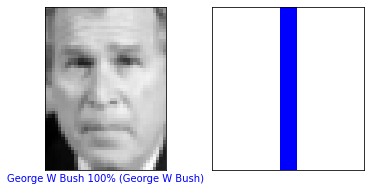

In [ ]:


i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, label_batch_test, image_batch_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  label_batch_test)
plt.show()

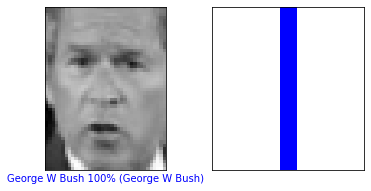

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, label_batch_test, image_batch_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  label_batch_test)
plt.show()

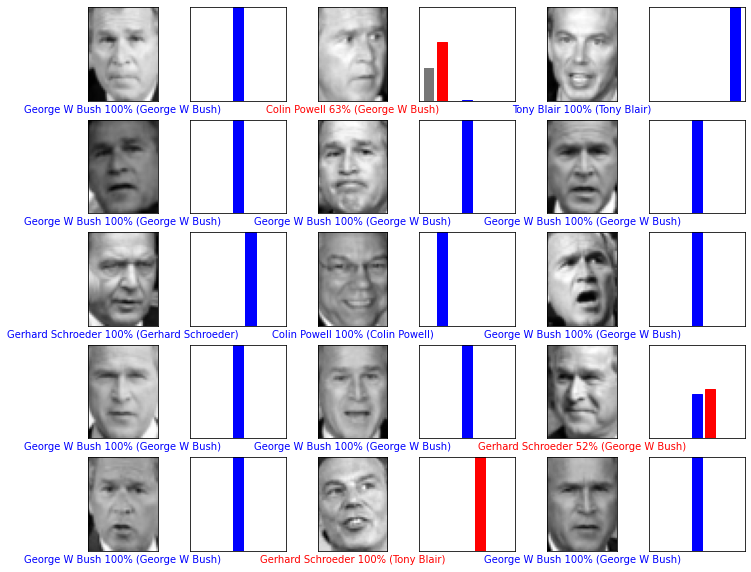

In [ ]:
# Plota o primeiro X test images, e as labels preditas, e as labels verdadeiras.
# Colore as predições corretas de azul e as incorretas de vermelho.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, label_batch_test, image_batch_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions,  label_batch_test)
plt.show()

#### Exporting to TFLite
https://www.tensorflow.org/lite/convert

In [ ]:
filename = "model_conv2D.h5"
model = load_model(path_model+filename)

export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


In [ ]:
#@title Selecionando a otimização desejada
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
  optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# Converte o modelo.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [optimization]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = 'model_conv2D.tflite'
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

In [ ]:
try:
  from google.colab import files
  files.download(tflite_model_file)
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
normalModel = os.stat(path_model+filename)
print("normalModel", normalModel)

normalModel os.stat_result(st_mode=33152, st_ino=54, st_dev=35, st_nlink=1, st_uid=0, st_gid=0, st_size=9188184, st_atime=1650317784, st_mtime=1650317779, st_ctime=1650317784)


In [ ]:
tfLiteModel = os.stat(tflite_model_file)
print("tfLiteModel: ", tfLiteModel)

tfLiteModel:  os.stat_result(st_mode=33188, st_ino=2506496, st_dev=36, st_nlink=1, st_uid=0, st_gid=0, st_size=1155264, st_atime=1650317936, st_mtime=1650317933, st_ctime=1650317933)


## Load TensorFlow SavedModel

Let's load TensorFlow model from SavedModel format. Because we used custom layer from TensorFlow Hub, we need to explicitly point out the implementation with `custom_obiects` param.

In [ ]:
path_model

'gdrive/My Drive/STUDY/PhD Electrical and Computer Eng - UTSA/2022_Spring/Advanced Robotics AI/Robotic Project/AI/Codes/Models/'

In [ ]:
# Load SavedModel
filename = "model_conv2D.h5"
model = load_model(path_model+filename)

print(model)
#face_id__model = load(FACE_ID_SAVED_MODEL)
#print(face_id_model)

### Check predictions on loaded model


Validation batch shape tells us that we have a batch of 32 images, with size and channels: 224x224x3.

Let's calculate predictions for the entire batch.

In [ ]:
#tf_model_predictions = flowers_model(val_image_batch)
#print("Prediction results shape:", tf_model_predictions.shape)

tf_model_predictions = model(image_batch_test)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (322, 7)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

'''tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()'''

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = target_names

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Ariel Sharon,Colin Powell,Donald Rumsfeld,George W Bush,Gerhard Schroeder,Hugo Chavez,Tony Blair
0,0.00000000,0.00000000,0.00000000e+00,1.00000000,0.00000000e+00,0.00000000e+00,8.91558928e-15
1,0.35607424,0.63220221,1.69256274e-17,0.01172364,3.27974679e-31,6.72120385e-19,3.32121033e-21
2,0.00000000,0.00000000,5.30142874e-30,0.00000000,0.00000000e+00,0.00000000e+00,1.00000000e+00
3,0.00000000,0.00000000,0.00000000e+00,1.00000000,7.51462636e-34,0.00000000e+00,0.00000000e+00
4,0.00000000,0.00000000,0.00000000e+00,1.00000000,0.00000000e+00,0.00000000e+00,1.63917901e-27


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = target_names[predicted_ids]

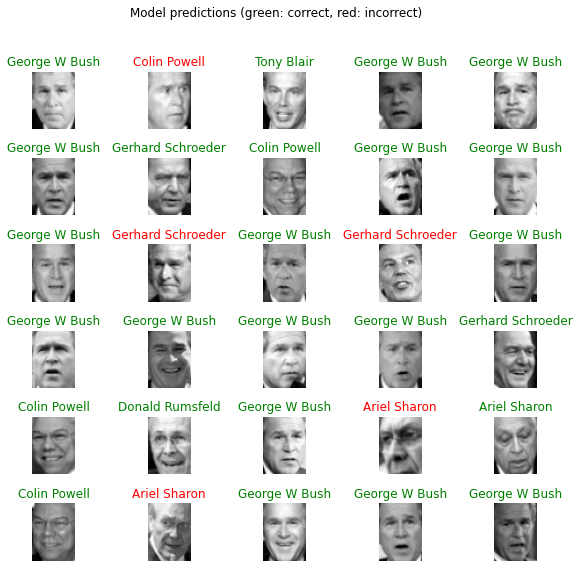

In [ ]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n], cmap="gray")
  color = "green" if predicted_ids[n] == label_batch_test[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Convert model to TFLite

Convert recently loaded model to TensorFlow Lite models (standard and quantized with a [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)).

Because of TensorFlow 2.0 nature, we'll need to convert TensorFlow model into concrete function and then do conversion to TFLite. More about it [here](https://www.tensorflow.org/lite/r2/convert/concrete_function).

In [ ]:
!mkdir "tflite_models"

In [ ]:
!ls

gdrive	model_conv2D.tflite  sample_data  saved_model  tflite_models


In [ ]:
TFLITE_MODEL = "tflite_models/face_id.tflite"
TFLITE_QUANT_MODEL = "tflite_models/face_id_quant.tflite"

In [ ]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

NameError: ignored

### Load TFLite model

Load TensorFlow lite model with interpreter interface.

In [ ]:
# Load TFLite model and see some details about input/output
TFLITE_MODEL = "tflite_models/face_id.tflite"
TFLITE_QUANT_MODEL = "tflite_models/face_id_quant.tflite"

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

ValueError: ignored

# DON'T NEED!!! 

#### Resize input and output tensors shapes

Input shape of loaded TFLite model is 1x224x224x3, what means that we can make predictions for single image.

Let's resize input and output tensors, so we can make predictions for batch of 32 images.

In [ ]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

RuntimeError: ignored

In [ ]:
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

NameError: ignored

In [ ]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = target_names

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

NameError: ignored

Now let's do the same for TFLite quantized model:
- Load model,
- Reshape input to handle batch of images,
- Run prediction

In [ ]:
# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL)

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

# Resize input and output tensors to handle batch of 32 images
tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter_quant.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter_quant.invoke()

tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)

== Input details ==
name: x
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  5]
type: <class 'numpy.float32'>

Prediction results shape: (32, 5)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe.columns = dataset_labels

print("Quantized TFLite model prediction results for the first elements")
tflite_q_pred_dataframe.head()

Quantized TFLite model prediction results for the first elements


,Daisy,Dandelion,Roses,Sunflowers,Tulips
0,0.99477381,0.00244763,0.00023104,0.00241640,0.00013117
1,0.00210885,0.27494249,0.00023566,0.69077367,0.03193940
2,0.00016670,0.99976414,0.00005705,0.00000267,0.00000937
3,0.55797166,0.14495583,0.14858168,0.03169078,0.11680005
4,0.00862213,0.00661955,0.00439752,0.51002896,0.47033188


## Compare prediction results

Now we will use Pandas to visualize results from all 3 models and find differences between them.

In [ ]:
# Concatenate results from all models

all_models_dataframe = pd.concat([tf_pred_dataframe, 
                                  tflite_pred_dataframe, 
                                  tflite_q_pred_dataframe], 
                                 keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                 axis='columns')
all_models_dataframe.head()

TF Model                                                      TFLite  \
        Daisy   Dandelion       Roses  Sunflowers      Tulips       Daisy   
0  0.99862337  0.00042410  0.00006596  0.00038340  0.00050305  0.99862337   
1  0.00002959  0.00025405  0.00000241  0.99308491  0.00662913  0.00002959   
2  0.00061904  0.99931717  0.00004889  0.00000371  0.00001118  0.00061904   
3  0.23130709  0.22594962  0.01116804  0.22426388  0.30731136  0.23130709   
4  0.00067187  0.00213364  0.01522027  0.02445348  0.95752066  0.00067188   

                                                  TFLite quantized  \
    Dandelion       Roses  Sunflowers      Tulips            Daisy   
0  0.00042411  0.00006596  0.00038340  0.00050306       0.99477381   
1  0.00025405  0.00000241  0.99308479  0.00662917       0.00210885   
2  0.99931729  0.00004889  0.00000371  0.00001118       0.00016670   
3  0.22595195  0.01116799  0.22426480  0.30730811       0.55797166   
4  0.00213367  0.01522030  0.02445374  0.95752037       0.00862213   

                                                   
    Dandelion       Roses  Sunflowers      Tulips  
0  0.00244763  0.00023104  0.00241640  0.00013117  
1  0.27494249  0.00023566  0.69077367  0.03193940  
2  0.99976414  0.00005705  0.00000267  0.00000937  
3  0.14495583  0.14858168  0.03169078  0.11680005  
4  0.00661955  0.00439752  0.51002896  0.47033188

In [ ]:
# Swap columns to hava side by side comparison

all_models_dataframe = all_models_dataframe.swaplevel(axis='columns')[tflite_pred_dataframe.columns]
all_models_dataframe.head()

Daisy                                Dandelion              \
     TF Model      TFLite TFLite quantized    TF Model      TFLite   
0  0.99862337  0.99862337       0.99477381  0.00042410  0.00042411   
1  0.00002959  0.00002959       0.00210885  0.00025405  0.00025405   
2  0.00061904  0.00061904       0.00016670  0.99931717  0.99931729   
3  0.23130709  0.23130709       0.55797166  0.22594962  0.22595195   
4  0.00067187  0.00067188       0.00862213  0.00213364  0.00213367   

                         Roses                               Sunflowers  \
  TFLite quantized    TF Model      TFLite TFLite quantized    TF Model   
0       0.00244763  0.00006596  0.00006596       0.00023104  0.00038340   
1       0.27494249  0.00000241  0.00000241       0.00023566  0.99308491   
2       0.99976414  0.00004889  0.00004889       0.00005705  0.00000371   
3       0.14495583  0.01116804  0.01116799       0.14858168  0.22426388   
4       0.00661955  0.01522027  0.01522030       0.00439752  0.02445348   

                                    Tulips                               
       TFLite TFLite quantized    TF Model      TFLite TFLite quantized  
0  0.00038340       0.00241640  0.00050305  0.00050306       0.00013117  
1  0.99308479       0.69077367  0.00662913  0.00662917       0.03193940  
2  0.00000371       0.00000267  0.00001118  0.00001118       0.00000937  
3  0.22426480       0.03169078  0.30731136  0.30730811       0.11680005  
4  0.02445374       0.51002896  0.95752066  0.95752037       0.47033188

In [ ]:
# Highlight TFLite models predictions that are different from original model

def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('TF Model', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

all_models_dataframe.style.apply(highlight_diff, axis=None)

As we can see, in most cases predictions are different between all models, usually by small factors. High-confidence predictions between TensorFlow and TensorFlow Lite models are very close to each other (in some cases there are even similar).  
Quantized model outstands the most, but this is the cost of optimizations (model weights 3-4 times less).

To make prediction results even more readable, let's simplify dataframes, to show only the highest-score prediction and the corresponding label.

In [ ]:
# Concatenation of argmax and max value for each row
def max_values_only(data):
  argmax_col = np.argmax(data, axis=1).reshape(-1, 1)
  max_col = np.max(data, axis=1).reshape(-1, 1)
  return np.concatenate([argmax_col, max_col], axis=1)

# Build simplified prediction tables
tf_model_pred_simplified = max_values_only(tf_model_predictions)
tflite_model_pred_simplified = max_values_only(tflite_model_predictions)
tflite_q_model_pred_simplified = max_values_only(tflite_q_model_predictions)

In [ ]:
# Build DataFrames and present example
columns_names = ["Label_id", "Confidence"]
tf_model_simple_dataframe = pd.DataFrame(tf_model_pred_simplified)
tf_model_simple_dataframe.columns = columns_names

tflite_model_simple_dataframe = pd.DataFrame(tflite_model_pred_simplified)
tflite_model_simple_dataframe.columns = columns_names

tflite_q_model_simple_dataframe = pd.DataFrame(tflite_q_model_pred_simplified)
tflite_q_model_simple_dataframe.columns = columns_names

tf_model_simple_dataframe.head()

,Label_id,Confidence
0,0.0,0.99862337
1,3.0,0.99308491
2,1.0,0.99931717
3,4.0,0.30731136
4,4.0,0.95752066


In [ ]:
# Concatenate results from all models
all_models_simple_dataframe = pd.concat([tf_model_simple_dataframe, 
                                         tflite_model_simple_dataframe, 
                                         tflite_q_model_simple_dataframe], 
                                        keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                        axis='columns')

# Swap columns for side-by-side comparison
all_models_simple_dataframe = all_models_simple_dataframe.swaplevel(axis='columns')[tf_model_simple_dataframe.columns]

# Highlight differences
all_models_simple_dataframe.style.apply(highlight_diff, axis=None)

## Visualize predictions from TFLite models

At the end let's visualize predictions from TensorFlow Lite and quantized TensorFlow Lite models.

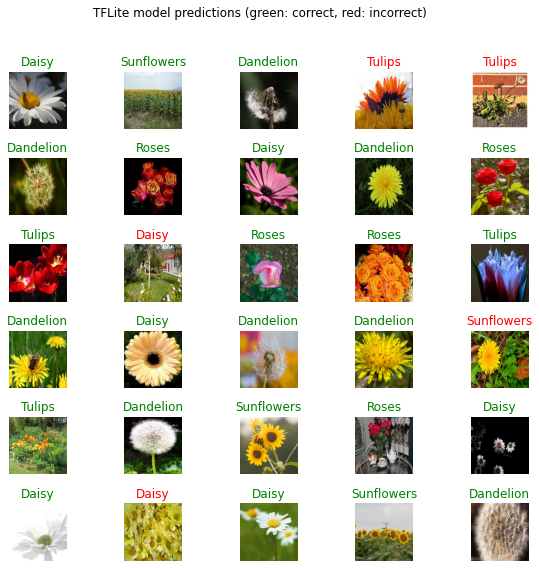

In [ ]:
# Print images batch and labels predictions for TFLite Model

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")

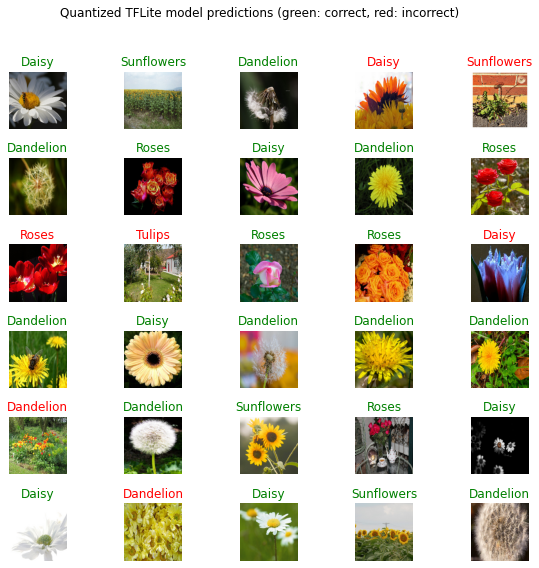

In [ ]:
# Print images batch and labels predictions for TFLite Model

tflite_q_predicted_ids = np.argmax(tflite_q_model_predictions, axis=-1)
tflite_q_predicted_labels = dataset_labels[tflite_q_predicted_ids]
tflite_q_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_q_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_q_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Quantized TFLite model predictions (green: correct, red: incorrect)")

## Export image validation batch

Export validation batch so it can be tested client side. Below we create compressed file containing all images named with the convention:

`n{}_true{}_pred{}.jpg`

where the first number is index, the second - true label index, the third - value predicted by TFLite moder generated in this notebook. Example file will look similar to this: `n0_true1_pred1.jpg`.

All images then will be put into client side testing code (res/assets in Android tests). Integration tests will run inference process on each image and then compare results with the ones saved in file names.

In [ ]:
from PIL import Image

In [ ]:
VAL_BATCH_DIR = "validation_batch"

In [ ]:
!mkdir {VAL_BATCH_DIR}

In [ ]:
# Export batch to *.jpg files with specific naming convention.
# Make sure they are exported in the full quality, otherwise the inference
# process will return different results. 

for n in range(32):
  filename = "n{:0.0f}_true{:0.0f}_pred{:0.0f}.jpg".format(
      n,
      true_label_ids[n],
      tflite_model_pred_simplified[n][0]
  )
  img_arr = np.copy(val_image_batch[n])
  img_arr *= 255
  img_arr = img_arr.astype("uint8")
  img11 = Image.fromarray(img_arr, 'RGB')
  img11.save("{}/{}".format(VAL_BATCH_DIR, filename), "JPEG", quality=100)

In [ ]:
!tar -zcvf {VAL_BATCH_DIR}.tar.gz {VAL_BATCH_DIR}

validation_batch/
validation_batch/n25_true0_pred0.jpg
validation_batch/n8_true1_pred1.jpg
validation_batch/n27_true0_pred0.jpg
validation_batch/n23_true2_pred2.jpg
validation_batch/n0_true0_pred0.jpg
validation_batch/n1_true3_pred3.jpg
validation_batch/n11_true2_pred0.jpg
validation_batch/n9_true2_pred2.jpg
validation_batch/n6_true2_pred2.jpg
validation_batch/n19_true1_pred3.jpg
validation_batch/n24_true0_pred0.jpg
validation_batch/n2_true1_pred1.jpg
validation_batch/n4_true1_pred4.jpg
validation_batch/n18_true1_pred1.jpg
validation_batch/n3_true3_pred4.jpg
validation_batch/n20_true4_pred4.jpg
validation_batch/n29_true1_pred1.jpg
validation_batch/n10_true4_pred4.jpg
validation_batch/n12_true2_pred2.jpg
validation_batch/n30_true4_pred4.jpg
validation_batch/n28_true3_pred3.jpg
validation_batch/n7_true0_pred0.jpg
validation_batch/n31_true0_pred0.jpg
validation_batch/n15_true1_pred1.jpg
validation_batch/n14_true4_pred4.jpg
validation_batch/n16_true0_pred0.jpg
validation_batch/n5_true1_pre

File `validation_batch.tar.gz` is ready to be downloaded, unpacked and put into client-side testing code.